<a href="https://colab.research.google.com/github/Immaczx/SemanticSegmentation/blob/master/Notebooks/FCNSegmentationZeaMaysSeeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/Immaczx/SemanticSegmentation.git

fatal: destination path 'SemanticSegmentation' already exists and is not an empty directory.


In [ ]:
from SemanticSegmentation import utils
import os
import math as m
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from gcpds.image_segmentation.datasets.segmentation import ZeaMaysSeeds
from gcpds.image_segmentation.losses import DiceCoefficient
from gcpds.image_segmentation.metrics import Jaccard, Sensitivity, Specificity
from gcpds.image_segmentation.metrics import DiceCoefficientMetric
from gcpds.image_segmentation.models import unet_baseline, fcn_baseline, segnet_baseline, res_unet_baseline

In [ ]:
image_size=256
out_channels = 1

model = fcn_baseline(input_shape=(image_size,image_size,3), out_channels=out_channels)
model.compile(loss=DiceCoefficient(), optimizer='Adam', metrics=[DiceCoefficientMetric(), Jaccard(), Sensitivity(), Specificity()])

 Number of images for Partition 1: 2016
 Number of images for Partition 2: 864
 Number of images for Partition 3: 320
10/10 [==============================] - 0s 43ms/step - loss: -0.9661 - DiceCoefficientMetric: -0.9661 - Jaccard: 0.9350 - Sensitivity: 0.9659 - Specificity: 0.9978


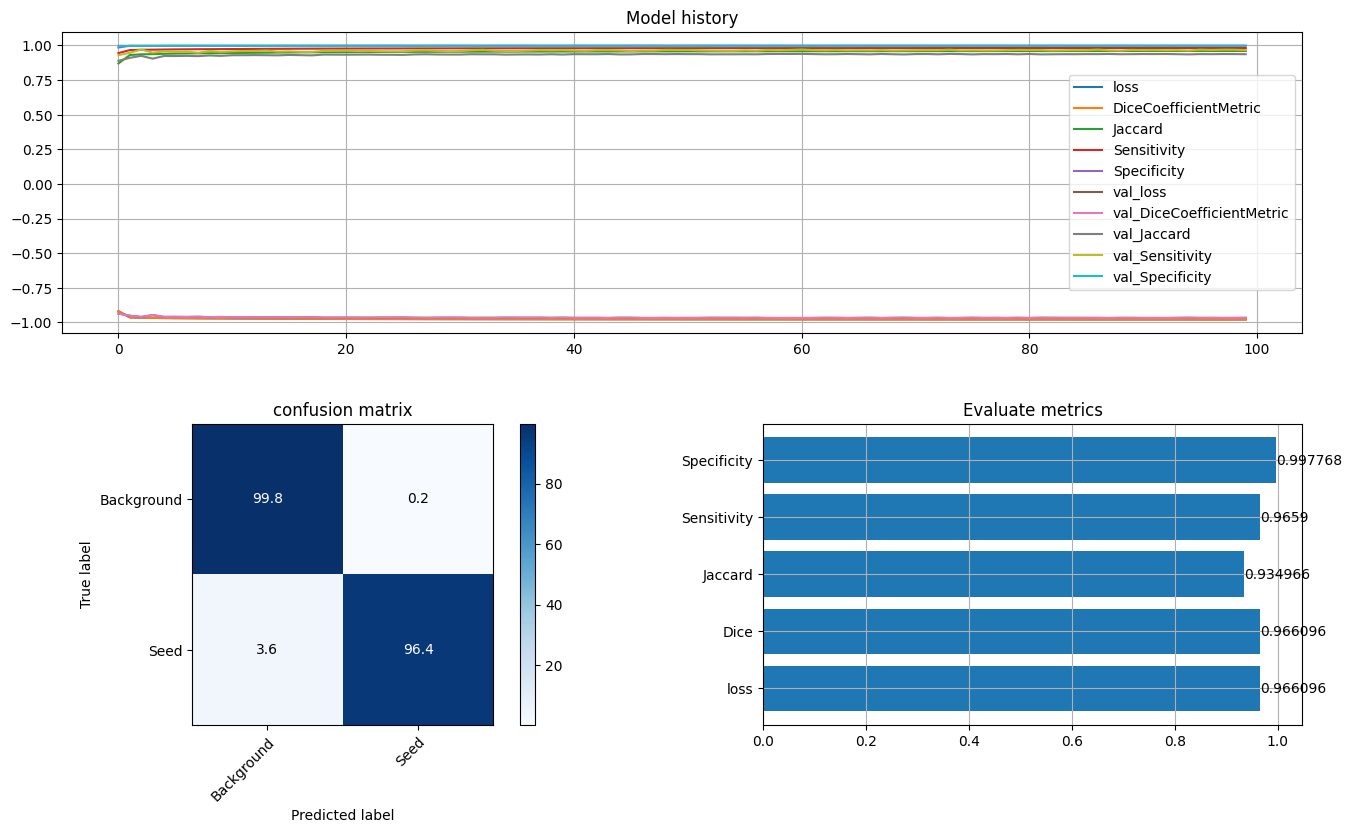

In [ ]:
num = np.random.randint(0, 100)
dataset = ZeaMaysSeeds(split=[0.1,0.3], seed = num)
train,val,test = dataset()

def preprocess(img,mask):
    img = tf.image.resize(img,(256,256))
    mask = tf.image.resize(mask,(256,256))#Ch 1: Seed, Ch 2: No germinate, Ch 3: germinate
    mask = tf.cast(mask>0, tf.float32)
    mask = mask[...,2][..., None]
    return img,mask

train = train.map(lambda x,y,id:preprocess(x,y))
train = train.batch(1)
val = val.map(lambda x,y,id:preprocess(x,y))
val = val.batch(1)
test = test.map(lambda x,y,id:preprocess(x,y))
test = test.batch(1)

train = train.cache()
val = val.cache()
test = test.cache()
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
model_history = model.fit(train,validation_data=val, epochs=100, verbose=0)
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(16,9))

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[1:, -1])

for i in model_history.history:
  ax1.plot(model_history.history[i],label=i)
ax1.set_title('Model history')
ax1.legend()
ax1.grid()
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
img_test = tf.zeros((0, 256, 256, 3), dtype=tf.float32)
mask_test = tf.zeros((0, 256, 256,1), dtype=tf.float32)

for img, mask in test:
    img_test = tf.concat([img_test, img], axis=0)
    mask_test = tf.concat([mask_test, mask], axis=0)
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
mask_pred = model.predict(img_test)
mask_pred = np.where(mask_pred > .5, 1, 0)
evaluate_history = model.evaluate(img_test, mask_test)
bars = ax3.barh(["loss","Dice","Jaccard","Sensitivity","Specificity"],np.abs(evaluate_history))
ax3.bar_label(bars)
ax3.set_title('Evaluate metrics')
ax3.grid()

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Then, convert the predicted and ground truth masks to single-dimensional arrays
pred_flat = tf.reshape(mask_pred, [-1])
true_flat = tf.reshape(mask_test, [-1])

# Plot the confusion matrix
utils.plot_confusion_matrix(true_flat, pred_flat, classes=['Background','Seed'], ax = ax2)
ax2.set_title('confusion matrix')

# Ajustar los espacios entre los subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Mostrar la figura
plt.show()
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
del train, val, test, dataset
tf.keras.backend.clear_session()
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------